In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import spacy
from pathlib import Path
import json
import re
import matplotlib.pyplot as plt
plt.style.use('sciml-style')

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis
# import pyLDAvis.sklearn
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

## Load Extracted Meta Data

Load a list of meta data extracted from each of the `.nc.gz` files. Each file is just represented as a big string without any additional structure.

In [2]:
import datefinder

with Path('data/processed/cru/cru_corpi.json').open('r') as handle:
    docs = json.load(handle)

doc_df = pd.DataFrame(docs)
doc_df.fillna('')

,CDI,Conventions,history,source,institution,title,comment,version_control,CDO,file_name,file_path,references,contact,acknowledgement,reference,version
0,Climate Data Interface version 1.9.5rc1 (http:...,CF-1.4,Tue Jul 24 14:54:34 2018: cdo -L -s copy crujr...,Data is provided from the Japanese 55-year Rea...,"Produced at the Climatic Research Unit, UEA, N...",CRUJRA Pressure: a forcing dataset based on JR...,A copy of JRA-55 year 1962 regridded to CRU 0....,V1.1: Regridding algorithm improvements and ot...,Climate Data Operators version 1.9.5rc1 (http:...,crujra.V1.1.5d.pres.1903.365d.noc.nc,data/raw/cru/badc/cru/data/cru_jra/cru_jra_1.1...,,,,,
1,Climate Data Interface version 1.9.5rc1 (http:...,CF-1.4,Fri Jul 27 16:29:59 2018: cdo -L -s copy crujr...,Data is provided from the Japanese 55-year Rea...,"Produced at the Climatic Research Unit, UEA, N...",CRUJRA Pressure: a forcing dataset based on JR...,JRA-55 regridded to CRU 0.5 grid,V1.1: Regridding algorithm improvements and ot...,Climate Data Operators version 1.9.5rc1 (http:...,crujra.V1.1.5d.pres.1979.365d.noc.nc,data/raw/cru/badc/cru/data/cru_jra/cru_jra_1.1...,,,,,
2,Climate Data Interface version 1.9.5rc1 (http:...,CF-1.4,Tue Jul 24 15:32:01 2018: cdo -L -s copy crujr...,Data is provided from the Japanese 55-year Rea...,"Produced at the Climatic Research Unit, UEA, N...",CRUJRA SPFH: a forcing dataset based on CRU TS...,A copy of JRA-55 year 1967 regridded to CRU 0....,V1.1: Regridding algorithm improvements and ot...,Climate Data Operators version 1.9.5rc1 (http:...,crujra.V1.1.5d.spfh.1905.365d.noc.nc,data/raw/cru/badc/cru/data/cru_jra/cru_jra_1.1...,,,,,
3,Climate Data Interface version 1.9.5rc1 (http:...,CF-1.4,Tue Jul 24 21:12:33 2018: cdo -L -s copy crujr...,Data is provided from the Japanese 55-year Rea...,"Produced at the Climatic Research Unit, UEA, N...",CRUJRA SPFH: a forcing dataset based on CRU TS...,A copy of JRA-55 year 1960 regridded to CRU 0....,V1.1: Regridding algorithm improvements and ot...,Climate Data Operators version 1.9.5rc1 (http:...,crujra.V1.1.5d.spfh.1920.365d.noc.nc,data/raw/cru/badc/cru/data/cru_jra/cru_jra_1.1...,,,,,
4,Climate Data Interface version 1.9.5rc1 (http:...,CF-1.4,Wed Jul 25 08:49:42 2018: cdo -L -s copy crujr...,Data is provided from the Japanese 55-year Rea...,"Produced at the Climatic Research Unit, UEA, N...",CRUJRA SPFH: a forcing dataset based on CRU TS...,A copy of JRA-55 year 1960 regridded to CRU 0....,V1.1: Regridding algorithm improvements and ot...,Climate Data Operators version 1.9.5rc1 (http:...,crujra.V1.1.5d.spfh.1944.365d.noc.nc,data/raw/cru/badc/cru/data/cru_jra/cru_jra_1.1...,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,,CF-1.4,Wed 15 Apr 2020 22:24:10 BST : User ianharris ...,Run ID = 2004151855. Data generated from:pre.2...,"Data held at British Atmospheric Data Centre, ...",CRU TS4.04 Precipitation,Access to these data is available to any regis...,,,cru_ts4.04.1931.1940.pre.dat.nc,data/raw/cru/badc/cru/data/cru_ts/cru_ts_4.04/...,Information on the data is available at http:/...,support@ceda.ac.uk,,,
185,,CF-1.4,Thu 16 Apr 2020 03:09:57 BST : User ianharris ...,Run ID = 2004151855. Data generated from:TMN d...,"Data held at British Atmospheric Data Centre, ...",CRU TS4.04 Minimum Temperature,Access to these data is available to any regis...,,,cru_ts4.04.1901.1910.tmn.dat.nc,data/raw/cru/badc/cru/data/cru_ts/cru_ts_4.04/...,Information on the data is available at http:/...,support@ceda.ac.uk,,,
186,,CF-1.4,Thu 16 Apr 2020 03:23:46 BST : User ianharris ...,Run ID = 2004151855. Data generated from:TMX d...,"Data held at British Atmospheric Data Centre, ...",CRU TS4.04 Maximum Temperature,Access to these data is available to any regis...,,,cru_ts4.04.1921.1930.tmx.dat.nc,data/raw/cru/badc/cru/data/cru_ts/cru_ts_4.04/...,Information on the data is available at http:/...,support@ceda.ac.uk,,,
187,,CF-1.4,Tue Feb 1 18:03:13 GMT 2011 : User badc : Pro...,Run ID = 1102011219\nData

In [54]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = doc_df['title'].tolist()
vectorizer = CountVectorizer(token_pattern=r'[a-zA-Z]{3,}', ngram_range=(1, 2), min_df=0., max_df=.95, stop_words='english', lowercase=True)
tokenizer = vectorizer.build_analyzer()
tokens = [tokenizer(c) for c in corpus]


id2word = corpora.Dictionary(tokens)
bow = [id2word.doc2bow(text) for text in tokens]

tfidf = gensim.models.TfidfModel(bow)
tf_idf_bow = [tfidf[b] for b in bow]

lda_model = gensim.models.ldamodel.LdaModel(corpus=bow,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

print('\nPerplexity: ', lda_model.log_perplexity(bow))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokens, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -3.6343453540941595

Coherence Score:  0.5583019950121065


In [5]:
from tqdm import tqdm
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, 
                                                random_state=42,
                                                passes=20,
                                                alpha='auto')
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

limit=15; start=2; step=1;
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=bow, texts=tokens, start=start, limit=limit, step=step)
# Show graph
x = range(start, limit, step)

coherence = pd.Series(coherence_values, index=x)

100%|██████████| 13/13 [00:27<00:00,  2.10s/it]


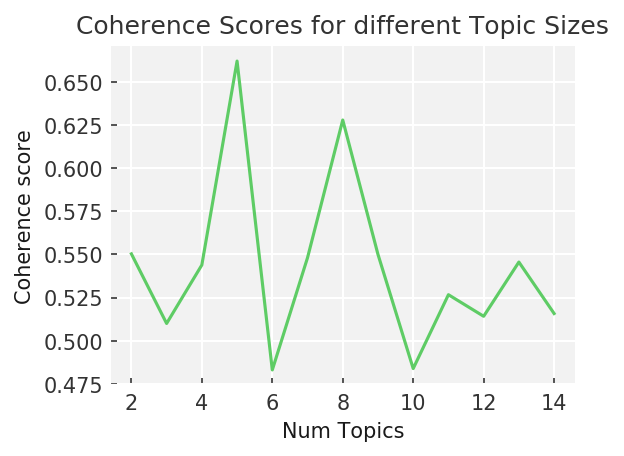

In [12]:
ax = coherence.plot()
ax.set_xlabel("Num Topics", fontsize=10)
ax.set_ylabel("Coherence score", fontsize=10)
plt.title('Coherence Scores for different Topic Sizes', fontsize=12)
plt.savefig('results/coherence.png', dpi=300)

In [13]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=bow,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=42,
                                           passes=20,
                                           alpha='auto')

In [225]:
topics = lda_model.get_topic_terms(1)
[id2word.id2token[t[0]] for t in topics]

['contact',
 'details',
 'badc',
 'academic',
 'use',
 'restrictions',
 'research',
 'data',
 'derived',
 'swr']

In [14]:
pyLDAvis.gensim.prepare(lda_model, bow, dictionary=id2word, mds='mmds')

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.172624  0.178194       1        1  40.426231
6     -0.325706  0.109194       2        1  15.625326
1     -0.219229  0.283466       3        1  15.345552
7      0.393869 -0.064891       4        1  14.806997
4     -0.084804 -0.342649       5        1   6.132933
0      0.155100 -0.320693       6        1   5.126805
2      0.241375  0.173479       7        1   2.369755
3      0.012019 -0.016100       8        1   0.166404, topic_info=              Term        Freq       Total Category  logprob  loglift
18             cru  142.000000  142.000000  Default  30.0000  30.0000
59     temperature   40.000000   40.000000  Default  29.0000  29.0000
78           count   39.000000   39.000000  Default  28.0000  28.0000
80         station   39.000000   39.000000  Default  27.0000  27.0000
81   station count   39.000000   39.000000  Default  26.0000  26.0000
..             ...         ...         ...      ...      ...      ...
4          dataset    0.042526   91.800690   Topic8  -4.6143  -1.2787
59     temperature    0.042479   40.656487   Topic8  -4.6154  -0.4654
37  radiation flux    0.042409   22.272326   Topic8  -4.6170   0.1348
36       radiation    0.042408   22.272324   Topic8  -4.6171   0.1348
32            flux    0.042406   22.272331   Topic8  -4.6171   0.1347

[388 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
98        6  0.560140        anomalies
0         1  0.588231            based
0         2  0.163398            based
0         3  0.250543            based
17        1  0.982608        based cru
...     ...       ...              ...
54        5  0.409892  vapour pressure
38        2  0.956883             wave
39        2  0.956881   wave radiation
27        3  0.946555             wind
28        3  0.946555     wind forcing

[140 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 7, 2, 8, 5, 1, 3, 4])

In [471]:
mat = gensim.matutils.corpus2csc(bow).T
mat = np.array(mat.todense())

columns = [id2word[x] for x in id2word]
pd.DataFrame(mat, index=doc_df.file_name, columns=columns)

,based,based jra,crujra,crujra pressure,dataset,dataset based,degree,degree grid,forcing,forcing dataset,...,cru maximum,maximum,maximum temperature,cru minimum,minimum,minimum temperature,anomalies,crutem,crutem temperature,temperature anomalies
file_name,,,,,,,,,,,,,,,,,,,,,
crujra.V1.1.5d.pres.1903.365d.noc.nc,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
crujra.V1.1.5d.pres.1979.365d.noc.nc,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
crujra.V1.1.5d.spfh.1905.365d.noc.nc,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
crujra.V1.1.5d.spfh.1920.365d.noc.nc,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
crujra.V1.1.5d.spfh.1944.365d.noc.nc,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cru_ts4.04.1931.1940.pre.dat.nc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cru_ts4.04.1901.1910.tmn.dat.nc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
cru_ts4.04.1921.1930.tmx.dat.nc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 189 samples in 0.000s...
[t-SNE] Computed neighbors for 189 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 189 / 189
[t-SNE] Mean sigma: 0.655856
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.258015
[t-SNE] KL divergence after 1000 iterations: 0.038247


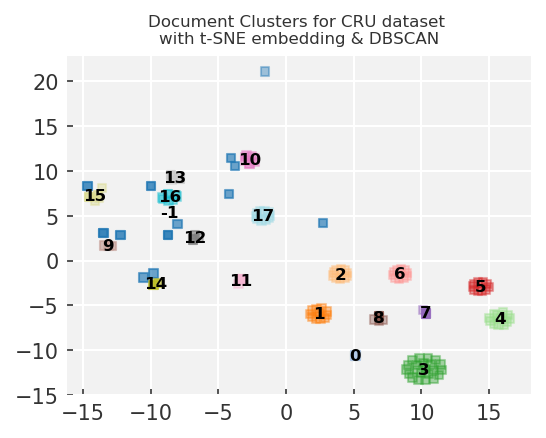

In [491]:
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from matplotlib import colors

mat = gensim.matutils.corpus2csc(bow).T
tsne = TSNE(n_components=2, verbose=1, random_state=0)
embed = tsne.fit_transform(mat)

dbscan = DBSCAN(eps=1)
clusters = dbscan.fit_predict(embed)


plt.scatter(x=embed[:, 0], y=embed[:, 1], cmap='tab20', c=clusters, alpha=.4)
for label in np.unique(dbscan.labels_):
    cluster_embedding = embed[dbscan.labels_ == label]
    
    plt.annotate(label, 
                 cluster_embedding.mean(axis=0),
                 horizontalalignment='center',
                 verticalalignment='center', weight='bold', size=8,
                 color='black') 
    
plt.title('Document Clusters for CRU dataset \nwith t-SNE embedding & DBSCAN', fontsize=8)
plt.savefig('results/doc-clusters-tsne-dbscan.png' )

In [509]:
clusters

array([ 0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  4,  4,  4,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
        8,  8,  8,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,
        5,  5,  6,  6,  6,  6,  0,  0,  0,  2,  2,  2,  2,  2,  2,  8,  8,
        8,  8,  3,  3,  3,  3,  3,  3,  3,  1,  1,  1,  1,  1,  1,  7,  7,
        7,  7,  3,  3,  3,  3,  3,  3,  9, 10, 11, 12, 13, 14, -1, 15, 15,
       -1, -1, 16, 16, 10, 10, -1, -1, 12,  9, 15, 15, -1, -1, -1, 13, 13,
       16, 15, -1, -1, 16, -1, -1, -1, 11, 17, 17, 17, 16, 15, -1, -1, 16,
       10, 11, 13,  9, 14, -1, -1,  9,  9, 11, -1, -1, 15, -1, 16, 16, -1,
       -1, -1, -1, 10, 10, 13, 17, 17, 15, -1, -1, -1, -1, 11, 11, 12, 12,
       -1, 17, 10, -1, 14, 13, 12, 17, 17, 14, 14, 11, 17, 10, 12, -1, 17,
       13, -1])

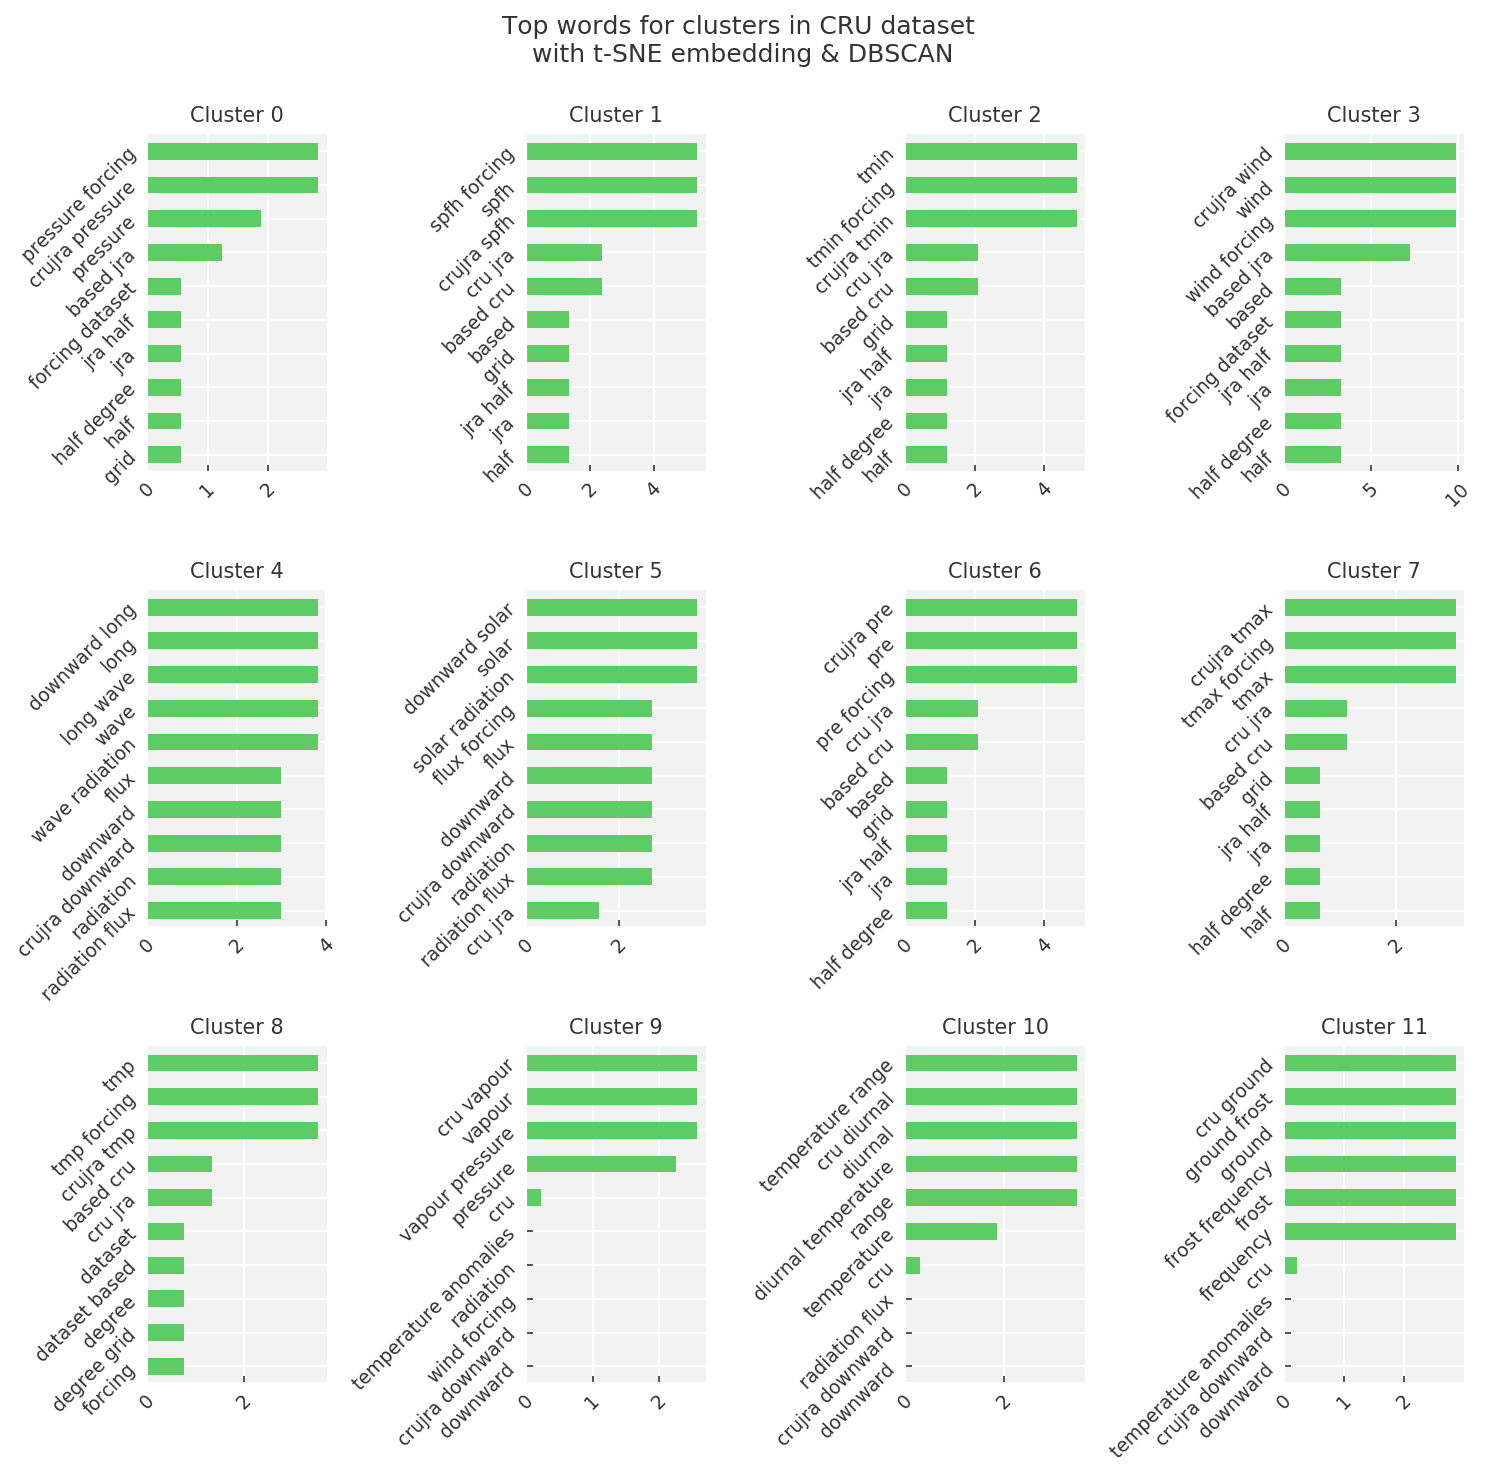

In [542]:
columns = [id2word[x] for x in id2word]
columns
fig, axes = plt.subplots(3, 4, figsize=(10,10))

dtm = pd.DataFrame(mat.todense(), index=doc_df.file_name, columns=columns)
for i, ax in enumerate(axes.flatten()):
    top_words = dtm.loc[clusters==i].sum(axis=0).sort_values(ascending=False)
    top_words.iloc[:10].plot(kind='barh', ax=ax)
    ax.invert_yaxis()
    ax.tick_params(axis='both', which='major', labelsize=9, rotation=45)
    ax.set_title('Cluster {}'.format(i), fontsize=10)
plt.tight_layout()

plt.suptitle('Top words for clusters in CRU dataset \nwith t-SNE embedding & DBSCAN', fontsize=12)
plt.subplots_adjust(top=0.9)
plt.savefig('results/doc-clusters-top-words.png', dpi=300)


In [17]:
import spacy

nlp = spacy.load("en_core_web_lg")

# for token in doc:

In [34]:
doc = nlp(doc_df.title.tolist()[0])
for e in doc.ents:
    print(e.text, e.label_)

CRUJRA PERSON
half CARDINAL


In [111]:
import nltk
nltk.download('averaged_perceptron_tagger')

corpus = doc_df['history'].tolist()

def get_named_entities(words):
    tagged = nltk.pos_tag(nltk.word_tokenize(words))
    entities = []
    for chunk in nltk.ne_chunk(tagged):
        if hasattr(chunk, 'label'):
            entities.append((chunk.label(), ' '.join(c[0] for c in chunk)))
    return entities

def extract_named_entities(doc_df):  
    corpus_entities = []
    for i, row in doc_df.iterrows():
        entities = get_named_entities(row['institution'])
        entities.extend(get_named_entities(row['comment']))
        entities.extend(get_named_entities(row['history']))
        corpus_entities.append(entities)
    return corpus_entities

boe = extract_named_entities(doc_df)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/lhs18285/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


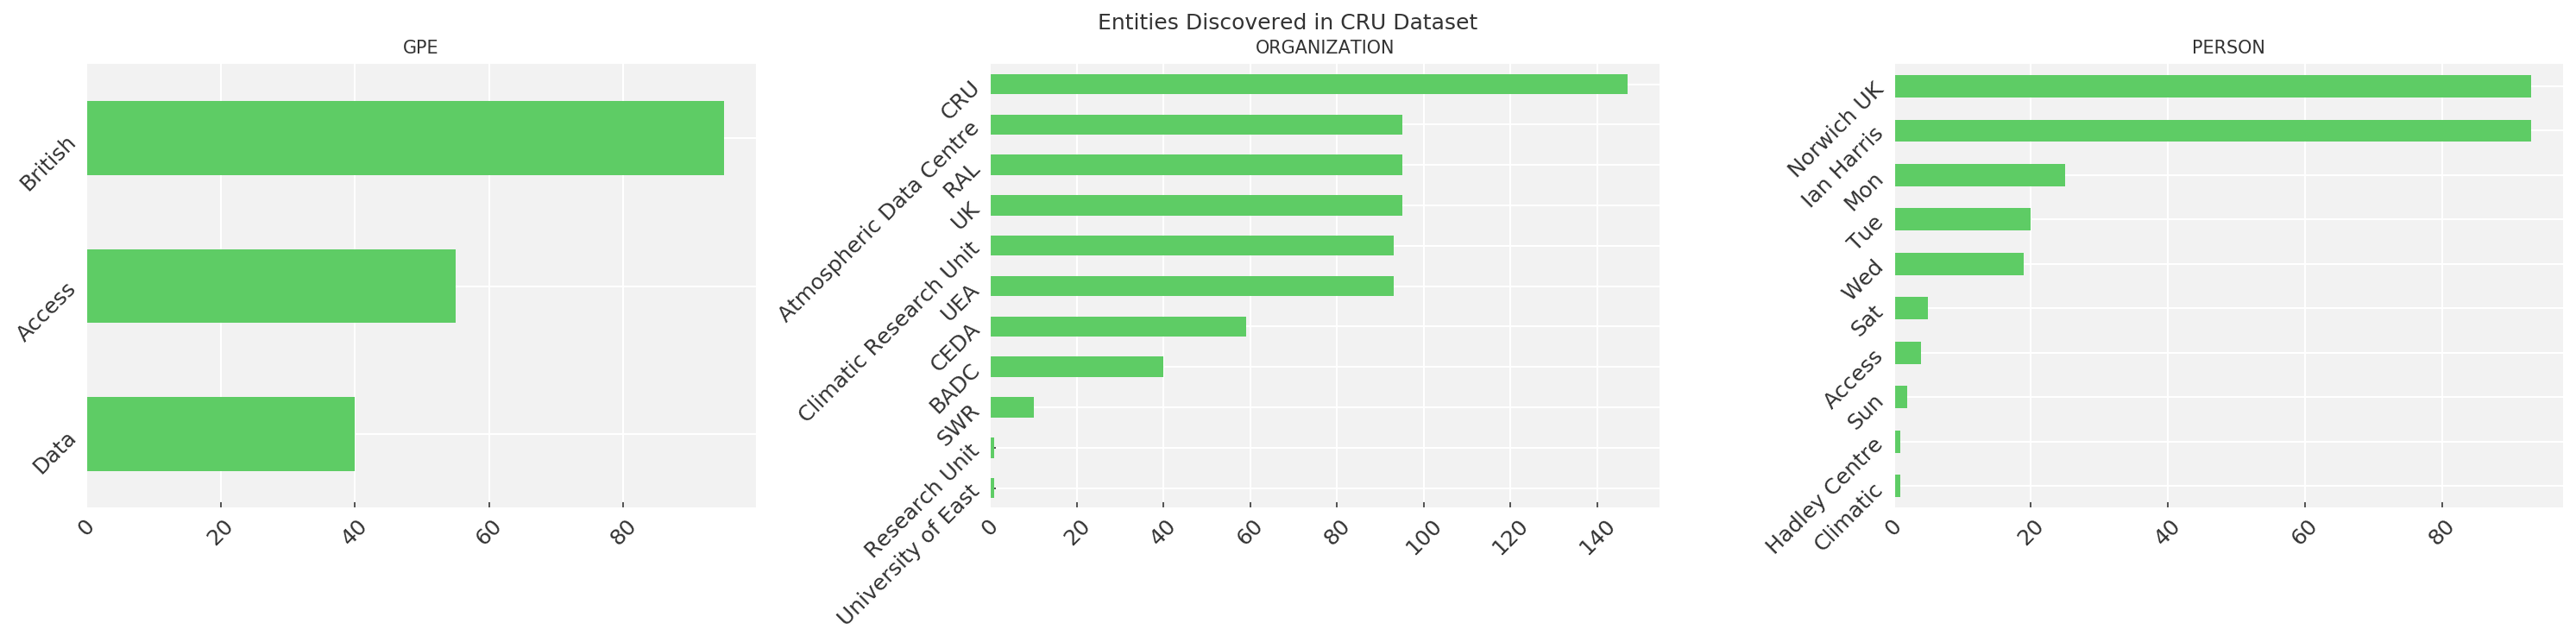

In [160]:
boe_flat = [e for es in boe for e in es]
entity_df = pd.DataFrame(boe_flat, columns=['Type', 'Name'])


groups = entity_df.groupby('Type')

fig, axes = plt.subplots(1, len(groups), figsize=(20, 5))
for ax, (ent_type, df) in zip(axes, groups):
    df = df.Name.value_counts().sort_values(ascending=False)
    df.plot(kind='barh', ax=ax)
    ax.invert_yaxis()
    ax.set_title(ent_type, fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=12, rotation=45)

plt.tight_layout()
plt.suptitle('Entities Discovered in CRU Dataset', fontsize=12)
plt.subplots_adjust(top=0.9)
plt.savefig('results/doc-entities.png', dpi=300)

In [101]:
df = cluster_data[0]
df

,0,1
CRU Ground Frost Frequency Data,ORG,0.795296
British Atmospheric Data,ORG,0.795296
Run Data,ORG,0.795296
BADC,ORG,0.795296
22:32:51,MONEY,0.795296
Access,PRODUCT,0.795296
CEDA,ORG,0.795296
Jun 17:49:08,PERSON,0.795296
BADC crujra pres,ORG,0.795296
raw cru badc cru,ORG,0.795296
